# [AMEX] Simple LGBM Starter for beginner (Eng/日本語)

This is a competiton to predict Default (=unable to pay Credit-card debt) for AMEX credit-card. From a look at the description in competition "Evaluation", there are difficult mathematical formula... but from a thought "in a nutshell, should we predict Default-ratio by each customer?", I tried to build as easy notebook as possible.   

AMEXのデフォルト（クレジットカードの支払が出来なくなる）を予測するコンペ。Evaluationを見ると、何ともムズカシイ数式が出ていますが、要は「顧客ごとにデフォルトするかしないかを予測すればいいんでしょ？」ということで、できるだけシンプルなNotebookを組んでみました。

**Credit to below links**  
for lightened Train & Test data
https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format


Please add lightened data set as follows in advance, since the original csv ones are super-heavy.  
コンペで提供されるデータセットは非常に重いので、事前に以下要領でデータセットをAddしておいてください。

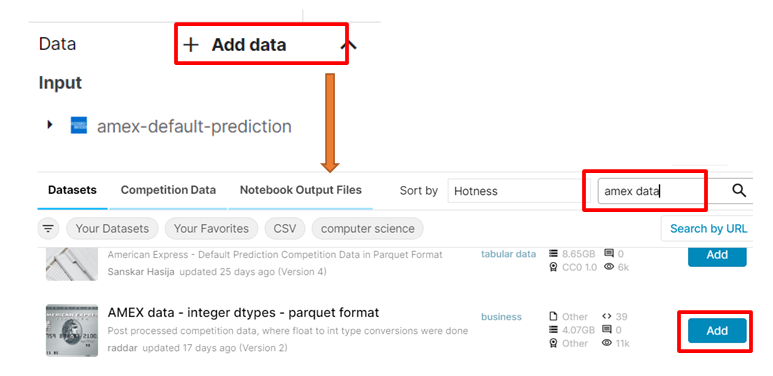

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# (1) Read Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgbm
from lightgbm import LGBMClassifier
pd.set_option("display.max_columns", None)

First, let's read Train data. It is OK to read all data, but it will cause Memory-over error when LGBM running for fitting, hence we'll read two(2) records per each customer(tail(2)). We can read a single record, but it will lead to a bit lower Public score. 

まずはTrainデータを読み込みます。全データを読み込めなくもないのですが、LGBMで学習する際にメモリーオーバーエラーが発生するので、顧客ごとに２レコードだけ読み込みます (tail(2))。１レコードだけ読み込んでも良いですが、学習データが減るので、Public Scoreが少し下がります。

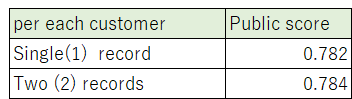

In [ ]:
%%time
train_df = pd.read_parquet('../input/amex-data-integer-dtypes-parquet-format/train.parquet').groupby('customer_ID').tail(2).set_index('customer_ID', drop=True).sort_index()
train_df

In [ ]:
train_labels = pd.read_csv('../input/amex-default-prediction/train_labels.csv').set_index('customer_ID', drop=True).sort_index()
train_labels

This Train labels is a label data pf each customer and "target" is also included here. Target "1" seems to stand for "Default" customer.  
There are 118k Default records, which is approx 26% out of total records (more than my initial thought!)  

このTrain labelsが顧客ごとのラベルで、かつターゲットもここに入っていて、1がDefault（支払い不能）になった顧客を表しています。  
Defaultになった顧客は118千レコードあり、Trainデータ全体の約26%を占めています.


In [ ]:
print(train_labels["target"].sum(), train_labels["target"].sum()/len(train_labels)*100,"%")

In [ ]:
%%time
train_df = pd.merge(train_df, train_labels, left_index=True, right_index=True)
train_df

Let's remove the following columns, since they are categorical according to the explanation in data overview.    

Dataの説明で「Categorical column」と説明されている以下のColumnはいったん学習から除外します。

In [ ]:
all_cols = train_df.columns
non_use_cols = ['S_2','B_30','B_38','D_114','D_116','D_117','D_120','D_126','D_63','D_64','D_66','D_68', 'target']
feature_cols = [col for col in all_cols if col not in non_use_cols]

In [ ]:
y = train_df['target'].copy()
x = train_df[feature_cols]

# (2) Build Model

Let's simply build a model using LGBMClassifier since the aim is to predict probability of Default or not.

Defaultするか否かの予測なので、シンプルにLGBMClassifierでモデルを組みます。

In [ ]:
model_lgbm = lgbm.LGBMClassifier(n_estimators = 300)

In [ ]:
del train_df
del train_labels

In [ ]:
%%time
model_lgbm.fit(x, y)

# (3) Read test data and predict

From a look at a sample submission file, it seems we need to predict 924,621 customer's Default probability. However, huge volume of records more than 11mil are included in Test data. Therefore, we'd like to extract a single record per each customer( tail(1) ). 

サンプルSubmissionファイルを見ると、全顧客（924,621）のDefault確率を予測するようですが、Testデータには11百万レコード以上という大量のデータが入っていますので、各顧客最後の1レコードを抽出します( tail(1) )。

In [ ]:
%%time
test_df = pd.read_parquet('../input/amex-data-integer-dtypes-parquet-format/test.parquet').groupby('customer_ID').tail(1).set_index('customer_ID', drop=True).sort_index()
test_df

In [ ]:
test_df = test_df[feature_cols]
y_pred  = model_lgbm.predict_proba(test_df)

We can predict the probability for "Will not default(0)" and "Will default(1)", using predict_proba.   

predict_probaを使うことで、各レコード（顧客）ごとに、「Defaultしない(0)確率」と「Defaultする(1)確率」を予測できます。

In [ ]:
df_y_pred = pd.DataFrame({"target0_prob":y_pred[:,0],"target1_prob":y_pred[:,1]})
df_y_pred

In [ ]:
sub = pd.read_csv('../input/amex-default-prediction/sample_submission.csv')
sub["prediction"] = y_pred[:,1]
sub.to_csv('submission.csv', index=False)
sub.head()